In [63]:

from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.master("local").appName("PySparkTest").getOrCreate()
# create a simple DataFrame
data = [("Alice", 1), ("Bob", 2), ("Charlie", 3), ("Dave", 4)]
df = spark.createDataFrame(data, ["Name", "Age"])

# show the DataFrame
df.show()

# stop the SparkSession
spark.stop()

+-------+---+
|   Name|Age|
+-------+---+
|  Alice|  1|
|    Bob|  2|
|Charlie|  3|
|   Dave|  4|
+-------+---+



In [64]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

df = spark.read.csv('work/OnlineRetail.csv',header=True,escape="\"")
df.show(5,0)


+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2,55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3,39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2,75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3,39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3,39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [65]:
df.count()  # Answer: 2,500
df.select('CustomerID').distinct().count() # Answer: 95


4373

In [66]:
from pyspark.sql.functions import *
from pyspark.sql.types import *




df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|            Israel|            4|
|           Iceland|            1|
+------------------+-------------+
only showing top 20 rows



In [67]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-12-10 16:21:00|
+-------------------+



In [68]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|0001-04-11 10:00:00|
+-------------------+



In [69]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|0001-04-11 10:00:00|
+-------------------+



In [70]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2,55     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3,39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2,75     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3,39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

In [71]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [72]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [73]:
df2.show(5,0)

+-------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5,95     |13047     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|
|2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2,55     |13748     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|
|3960   |536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 9:32|2,55     |17850     |United Kingdom|2012-01-10 09:32:00|2012-01-10 08:26:00|
|3960   |536375   |710

In [74]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [75]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [76]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|15271     |24       |
|15555     |37       |
|16320     |47       |
+----------+---------+
only showing top 5 rows



In [77]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [78]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [79]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [80]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [81]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [82]:
finaldf = finaldf.na.drop(subset=["monetary_value"])


In [83]:
finaldf.printSchema()

root
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary_value: double (nullable = true)
 |-- CustomerID: string (nullable = true)



In [84]:

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [85]:
data_scale_output.select('standardized').show(2,truncate=False)

+--------------------------------------------------------------+
|standardized                                                  |
+--------------------------------------------------------------+
|[-0.0015898112497777397,0.11421176036732086,1.378424954243093]|
|[-0.0019430583170315387,1.4657175913806177,0.3063166564984651]|
+--------------------------------------------------------------+
only showing top 2 rows



In [86]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

Exception ignored in: <function JavaWrapper.__del__ at 0x7f8a9350d3f0>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


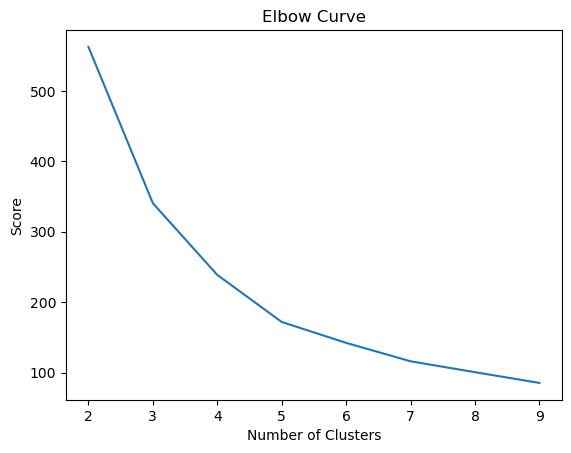

In [87]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [88]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [89]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+------------+---------+--------------+----------+---------------------------+--------------------------------------------------------------+----------+
|recency     |frequency|monetary_value|CustomerID|features                   |standardized                                                  |prediction|
+------------+---------+--------------+----------+---------------------------+--------------------------------------------------------------+----------+
|-47348280   |6        |162.0         |12394     |[-4.734828E7,6.0,162.0]    |[-0.0015898112497777397,0.11421176036732086,1.378424954243093]|0         |
|-57868800   |77       |36.0          |12637     |[-5.78688E7,77.0,36.0]     |[-0.0019430583170315387,1.4657175913806177,0.3063166564984651]|0         |
|-63200636760|29       |36.0          |12710     |[-6.320063676E10,29.0,36.0]|[-2.122085180584481,0.5520235084420508,0.3063166564984651]    |3         |
|-63198042300|14       |40.0          |12816     |[-6.31980423E10,14.0,40.0] |[-2.

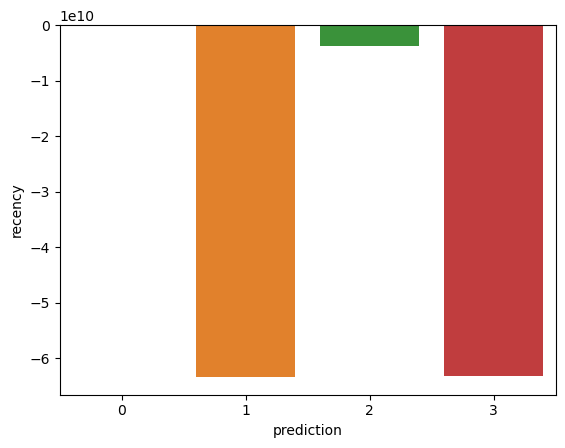

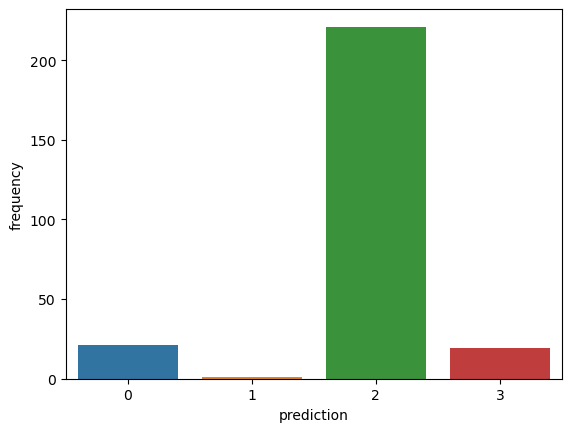

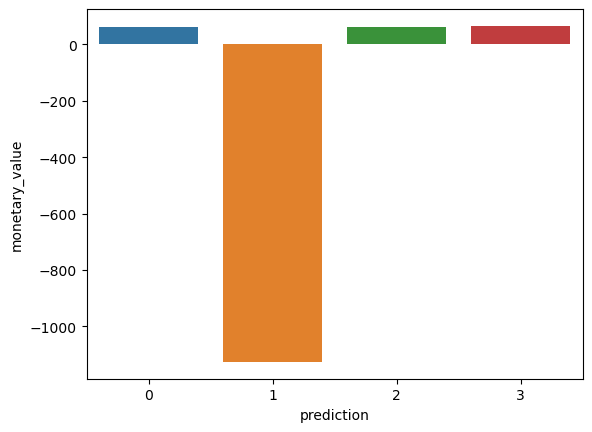

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

In [91]:
spark.stop()